In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from diffusers import DDPMScheduler, DDIMScheduler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os

from torch.utils.data import Subset

from diffusers.models.embeddings import TimestepEmbedding, get_timestep_embedding

from torchmetrics import JaccardIndex

from torchvision.transforms import InterpolationMode





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

DATA_DIR = './data'
BATCH_SIZE = 64

BASELINE_MODEL = "unet"  # Options: "unet"
print(f"Selected baseline model: {BASELINE_MODEL}")

BINARY_SEGMENTATION = True  # if False → 3-class (Pet, Background, Boundary)
NUM_CLASSES = 2 if BINARY_SEGMENTATION else 3
print(f"Segmentation mode: {'Binary' if BINARY_SEGMENTATION else '3-class'} ({NUM_CLASSES} output channel(s))")

USE_SUBSET = True
SUBSET_RATIO=0.2

MODEL_CONFIGS = {
    "unet": {
        "image_size": 128,
        "normalize": False
    },
}

config = MODEL_CONFIGS[BASELINE_MODEL]
IMAGE_SIZE = config["image_size"]
print(f"Using image size: {IMAGE_SIZE}x{IMAGE_SIZE}")

Using device: cuda
GPU: NVIDIA L4
Selected baseline model: unet
Segmentation mode: Binary (2 output channel(s))
Using image size: 128x128


In [ ]:
# Initialize selected baseline model
model_path = f'baseline_{BASELINE_MODEL}_{NUM_CLASSES}_classes.pth'
print(model_path)

baseline_unet_2_classes.pth


In [ ]:

image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),              # -> [0,1]
    transforms.Lambda(lambda x: x * 2 - 1)  # -> [-1,1]
])

mask_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.NEAREST),
    transforms.PILToTensor()  # returns uint8 tensor shape (1, H, W) with values {1,2,3} for Oxford pet
])


def preprocess_mask_to_onehot(mask_tensor):
    """
    mask_tensor: (1,H,W) uint8 or (H,W)
    returns: one-hot float tensor (C, H, W) with classes in [0..NUM_CLASSES-1]
    For BINARY_SEGMENTATION: foreground is class 1 or 3 in OxfordIIITPet (pet + boundary).
    """
    # ensure (H,W)
    if mask_tensor.ndim == 3:
        mask = mask_tensor.squeeze(0).long()
    else:
        mask = mask_tensor.long()

    # Oxford labels: 1=pet, 2=background, 3=boundary
    if BINARY_SEGMENTATION:
        # foreground: pet OR boundary -> 1, background -> 0
        mask = ((mask == 1) | (mask == 3)).long()
    else:
        # map [1,2,3] -> [0,1,2]
        mask = (mask - 1).clamp(0, 2).long()

    # one-hot -> (H, W, C) then permute to (C, H, W)
    mask_oh = F.one_hot(mask, num_classes=NUM_CLASSES).permute(2, 0, 1).float()
    return mask_oh


Original sizes: 3680 3669
Final split: 1175 train / 294 test
Train loader batches: 19, Test loader batches: 5
image batch shape: torch.Size([64, 3, 128, 128]) min/max: -1.0 1.0
mask batch shape: torch.Size([64, 2, 128, 128]) unique values in masks: tensor([0., 1.])


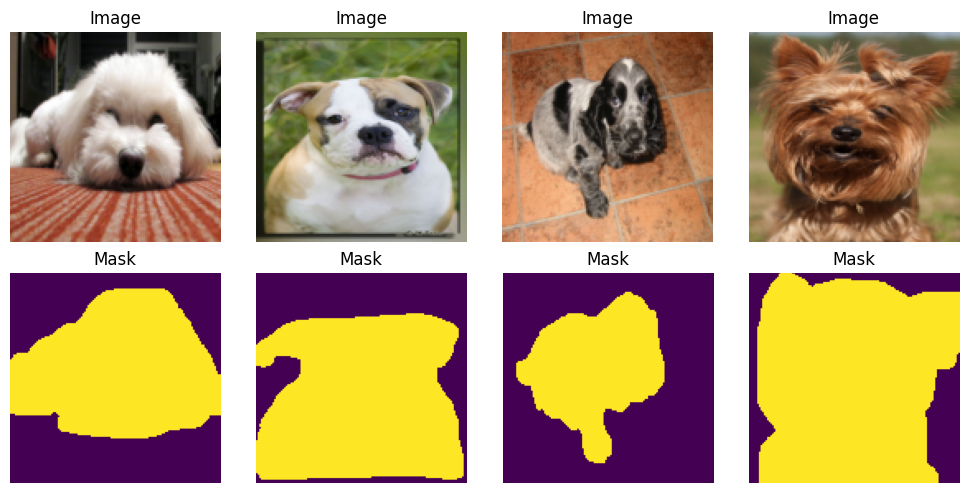

In [ ]:
# Load full datasets
train_ds = datasets.OxfordIIITPet(
    DATA_DIR, split="trainval", download=True, target_types="segmentation",
    transform=image_transform, target_transform=mask_transform
)
test_ds = datasets.OxfordIIITPet(
    DATA_DIR, split="test", download=True, target_types="segmentation",
    transform=image_transform, target_transform=mask_transform
)

from torch.utils.data import ConcatDataset, Subset
import numpy as np
from torchvision import datasets

# Load full original datasets (trainval + test)
trainval_ds = datasets.OxfordIIITPet(
    DATA_DIR, split="trainval", download=True, target_types="segmentation",
    transform=image_transform, target_transform=mask_transform
)
test_ds_full = datasets.OxfordIIITPet(
    DATA_DIR, split="test", download=True, target_types="segmentation",
    transform=image_transform, target_transform=mask_transform
)

print("Original sizes:", len(trainval_ds), len(test_ds_full))

# Combine both to treat as one dataset (full ~7.3k samples)
full_combined = ConcatDataset([trainval_ds, test_ds_full])
total = len(full_combined)

# Use only half of the total dataset
USE_FRACTION = 0.2
subset_size = int(total * USE_FRACTION)

rng = np.random.default_rng(42)
all_indices = rng.permutation(total)
subset_indices = all_indices[:subset_size]

subset_ds = Subset(full_combined, subset_indices)

#  Now split that subset 80/20 into train/test
train_frac = 0.8
n_train = int(subset_size * train_frac)

train_idx = subset_indices[:n_train]
test_idx = subset_indices[n_train:]

train_ds = Subset(full_combined, train_idx)
test_ds  = Subset(full_combined, test_idx)

print(f"Final split: {len(train_ds)} train / {len(test_ds)} test")



def collate_fn(batch):
    """
    batch: list of tuples (image_tensor, mask_tensor_from_mask_transform)
    Returns:
      images : (B, 3, H, W) in [-1,1]
      masks  : (B, NUM_CLASSES, H, W) one-hot floats
    """
    images, masks_raw = zip(*batch)
    images = torch.stack(images)  # (B,3,H,W)
    masks_oh = torch.stack([preprocess_mask_to_onehot(m) for m in masks_raw])  # (B,C,H,W)
    return images, masks_oh

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train loader batches: {len(train_loader)}, Test loader batches: {len(test_loader)}")


# Inspect a few samples
images, masks = next(iter(train_loader))
print("image batch shape:", images.shape, "min/max:", images.min().item(), images.max().item())
print("mask batch shape:", masks.shape, "unique values in masks:", torch.unique(masks) )

# Denormalization helper
def denormalize(img, mean, std):
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Visualize samples
n_samples = min(BATCH_SIZE, 4)
plt.figure(figsize=(10, 5))
for i in range(n_samples):
    img = images[i]
    mask = masks[i].squeeze()

    img = img.permute(1, 2, 0).numpy()
    img = ((img + 1) / 2).clip(0, 1)
    mask = mask.numpy()

    plt.subplot(2, n_samples, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(2, n_samples, i + 1 + n_samples)
    mask_vis = mask.argmax(0)
    plt.imshow(mask_vis)
    plt.axis("off")
    plt.title("Mask")

plt.tight_layout()
plt.show()

In [ ]:


# Define U-Net architecture
class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, base=64):
        super().__init__()
        self.enc1 = self._conv_block(in_ch, base)
        self.enc2 = self._conv_block(base, base * 2)
        self.enc3 = self._conv_block(base * 2, base * 4)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = self._conv_block(base * 4 + base * 2, base * 2)
        self.dec1 = self._conv_block(base * 2 + base, base)
        self.final = nn.Conv2d(base, out_ch, kernel_size=1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.up(e3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.final(d1)

baseline_model = UNetSmall(in_ch=3, out_ch=NUM_CLASSES).to(device)
print("Initialized custom U-Net baseline model.")


# Model summary
total_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Baseline model parameters: {total_params:,}")


Initialized custom U-Net baseline model.
Baseline model parameters: 1,885,762


In [ ]:
!pip install segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}...")
    baseline_model.load_state_dict(torch.load(model_path, map_location=device))
    baseline_model.eval()
else:
    print(f"No pre-trained model found at {model_path}. Training new model...")
    num_epochs = 75
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-4)
    baseline_model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)           # [-1,1]
            masks = masks.to(device)             # (B,C,H,W) one-hot floats

            optimizer.zero_grad()
            outputs = baseline_model(images)     # (B, NUM_CLASSES, H, W) raw logits

            # CrossEntropyLoss expects (B,C,H,W) logits and (B,H,W) class indices
            target_indices = masks.argmax(dim=1).long()
            loss = criterion(outputs, target_indices)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

    # Save trained model
    torch.save(baseline_model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    print("Baseline training completed!")

# import segmentation_models_pytorch as smp

# import segmentation_models_pytorch as smp
# from torchvision import transforms

# # Get preprocessing for the chosen encoder
# ENCODER = "resnet34"  # or "mobilenet_v2", etc.
# ENCODER_WEIGHTS = "imagenet"

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# image_transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),  # [0,1]
#     transforms.Lambda(lambda x: preprocessing_fn(x.permute(1,2,0).numpy()).transpose(2,0,1).copy()),
#     transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float))
# ])

# if BASELINE_MODEL.lower() == "unet":
#     baseline_model = smp.Unet(
#         encoder_name="resnet34",        # or "efficientnet-b0", "mobilenet_v2", etc.
#         encoder_weights="imagenet",     # use pretrained ImageNet encoder
#         in_channels=3,                  # 3 for RGB
#         classes=NUM_CLASSES,            # 2 for binary, 3 for multiclass
#         activation=None                 # keep logits (softmax/sigmoid later)
#     ).to(device)
#     print("Initialized pretrained U-Net (ResNet-34 encoder) from segmentation_models_pytorch.")


# Sanity check
baseline_model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    sample_imgs = sample_imgs.to(device)
    sample_logits = baseline_model(sample_imgs)
    print("Sanity - baseline output shape:", sample_logits.shape)


Loading pre-trained model from baseline_unet_2_classes.pth...
Sanity - baseline output shape: torch.Size([64, 2, 128, 128])


Baseline Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Baseline Mean IoU: 0.7655713438987732


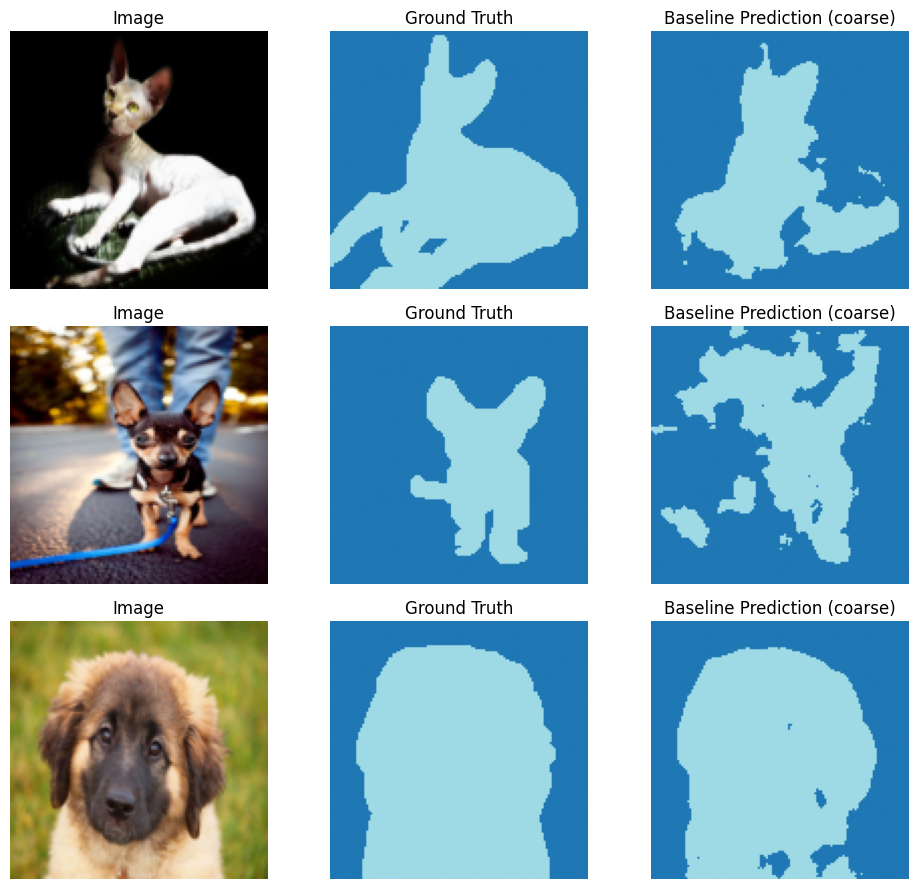

In [ ]:
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(device)
baseline_model.eval()
ious = []
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Baseline Eval"):
        images = images.to(device)
        masks = masks.to(device)
        logits = baseline_model(images)
        preds = torch.argmax(logits, dim=1)
        targets = masks.argmax(dim=1)
        iou = iou_metric(preds, targets)
        ious.append(iou.item())
mean_iou = float(np.mean(ious)) if len(ious) > 0 else 0.0
print("Baseline Mean IoU:", mean_iou)

# Visualization
n_vis = 3
images, masks = next(iter(test_loader))
images, masks = images[:n_vis].to(device), masks[:n_vis].to(device)

with torch.no_grad():
    logits = baseline_model(images)
    preds = torch.argmax(logits, dim=1)   # (n_vis, H, W)

plt.figure(figsize=(10, n_vis * 3))
for i in range(n_vis):
    img = images[i].cpu().permute(1, 2, 0).numpy()   # (H, W, 3), in [-1,1]
    img_disp = ((img + 1) / 2).clip(0, 1)            # map to [0,1] for display

    gt = masks[i].argmax(dim=0).cpu().numpy()       # (H, W)
    pr = preds[i].cpu().numpy()                     # (H, W)

    plt.subplot(n_vis, 3, i * 3 + 1)
    plt.imshow(img_disp)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(n_vis, 3, i * 3 + 2)
    plt.imshow(gt, cmap="tab20")
    plt.axis("off")
    plt.title("Ground Truth")

    plt.subplot(n_vis, 3, i * 3 + 3)
    plt.imshow(pr, cmap="tab20")
    plt.axis("off")
    plt.title("Baseline Prediction (coarse)")

plt.tight_layout()
plt.show()


In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
from diffusers import UNet2DModel, DDPMScheduler

# in_channels = image(3) + baseline_probs(NUM_CLASSES) + noisy_mask(NUM_CLASSES)
in_channels = 3 + NUM_CLASSES + NUM_CLASSES
out_channels = NUM_CLASSES  # model predicts noise for each mask channel (epsilon)

# -------- model ----------
refiner = UNet2DModel(
    sample_size=IMAGE_SIZE,
    in_channels=in_channels,
    out_channels=out_channels,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)
refiner.to(device)

# -------- scheduler (DDPM) ----------
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="scaled_linear",
    prediction_type="epsilon",  # we train to predict epsilon (noise)
)

# -------- optimizer ----------
optimizer = torch.optim.AdamW(refiner.parameters(), lr=1e-4)

# -------- training loop (toy) ----------
num_epochs = 75
log_every = 50
global_step = 0
refiner.train()

for epoch in range(num_epochs):
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)       # [-1,1]
        masks = masks.to(device)         # (B, C, H, W) one-hot floats
        bsz = images.size(0)

        # sample random timesteps per image
        t = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=device).long()

        # forward diffusion: x_t = sqrt(alpha_bar)*x0 + sqrt(1-alpha_bar)*noise
        noise = torch.randn_like(masks).to(device)
        masks_noisy = noise_scheduler.add_noise(masks, noise, t)

        #get coarse mask
        baseline_model.eval()
        with torch.no_grad():
            baseline_logits = baseline_model(images)                 # (B, NUM_CLASSES, H, W)
            baseline_probs = torch.softmax(baseline_logits, dim=1)   # per-pixel probabilities (B, C, H, W)

        # Optionally rescale baseline_probs to match image range (images are [-1,1])
        # baseline_probs_scaled = baseline_probs * 2 - 1
        baseline_probs_scaled = baseline_probs  # keep in [0,1], refiner will learn mapping.

        # concat inputs: images ([-1,1]), baseline_probs ([0,1]), masks_noisy (~continuous)
        # input_concat = torch.cat([images, baseline_probs_scaled, masks_noisy], dim=1)
        input_concat = torch.cat([images, masks, masks_noisy], dim=1)


        # predict noise (epsilon)
        model_out = refiner(input_concat, t)
        pred_noise = model_out.sample  # (B, NUM_CLASSES, H, W)

        # simple MSE loss on noise
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        global_step += 1
        if global_step % log_every == 0:
            print(f"step {global_step} | loss {loss.item():.4f}")

Epoch 1/75:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 2/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 50 | loss 0.2635


Epoch 4/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 100 | loss 0.1622


Epoch 7/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 150 | loss 0.0783


Epoch 9/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 200 | loss 0.0614


Epoch 12/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 250 | loss 0.0604


Epoch 15/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 300 | loss 0.0487


Epoch 17/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 350 | loss 0.0457


Epoch 20/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 21/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 22/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 400 | loss 0.0286


Epoch 23/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 24/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 450 | loss 0.0277


Epoch 25/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 26/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 27/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 500 | loss 0.0310


Epoch 28/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 29/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 550 | loss 0.0252


Epoch 30/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 31/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 32/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 600 | loss 0.0193


Epoch 33/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 34/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 35/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 650 | loss 0.0186


Epoch 36/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 37/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 700 | loss 0.0129


Epoch 38/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 39/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 40/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 750 | loss 0.0185


Epoch 41/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 42/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 43/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 800 | loss 0.0121


Epoch 44/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 45/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 850 | loss 0.0140


Epoch 46/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 47/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 48/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 900 | loss 0.0105


Epoch 49/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 50/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 950 | loss 0.0102


Epoch 51/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 52/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 53/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1000 | loss 0.0106


Epoch 54/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 55/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 56/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1050 | loss 0.0102


Epoch 57/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 58/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1100 | loss 0.0095


Epoch 59/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 60/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 61/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1150 | loss 0.0173


Epoch 62/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 63/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 64/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1200 | loss 0.0073


Epoch 65/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 66/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1250 | loss 0.0073


Epoch 67/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 68/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 69/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1300 | loss 0.0066


Epoch 70/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 71/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 72/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1350 | loss 0.0070


Epoch 73/75:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 74/75:   0%|          | 0/19 [00:00<?, ?it/s]

step 1400 | loss 0.0057


Epoch 75/75:   0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
torch.save(refiner.state_dict(), "refiner_unet2dmodel.pth")
print("Saved refiner model to refiner_unet2dmodel.pth")

Saved refiner model to refiner_unet2dmodel.pth


In [ ]:
torch.save(refiner.state_dict(), "refiner_unet2dmodel_sanityCHECK.pth")
print("Saved refiner model to refiner_unet2dmodel_sanityCHECK.pth")

Saved refiner model to refiner_unet2dmodel_sanityCHECK.pth


In [ ]:
from torchmetrics import JaccardIndex
print("Evaluating diffusion refiner on test set...")
refiner.eval()
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(device)
ious = []

INFERENCE_STEPS = 50  # reduce to e.g. 50 for quick debug

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating Refiner"):
        images = images.to(device)
        masks = masks.to(device)
        bsz = images.size(0)

        # initial latent (noise) with same shape as masks
        pred_mask = torch.randn_like(masks).to(device)

        # baseline coarse probabilities (no grad)
        baseline_model.eval()
        with torch.no_grad():
            baseline_logits = baseline_model(images)
            baseline_probs = torch.softmax(baseline_logits, dim=1)

        # set timesteps for inference
        noise_scheduler.set_timesteps(INFERENCE_STEPS, device=device)

        # reverse diffusion loop
        for t in noise_scheduler.timesteps:
            # input_concat = torch.cat([images, baseline_probs, pred_mask], dim=1)

            input_concat = torch.cat([images, masks, pred_mask], dim=1)

            model_out = refiner(input_concat, t)
            pred = model_out.sample
            step_out = noise_scheduler.step(pred, t, pred_mask)
            pred_mask = step_out.prev_sample

        # convert final continuous pred_mask to class labels via softmax + argmax
        pred_probs = torch.softmax(pred_mask, dim=1)
        preds = torch.argmax(pred_probs, dim=1)        # (B, H, W)
        targets = masks.argmax(dim=1)                  # (B, H, W)

        iou = iou_metric(preds, targets)
        ious.append(iou.item())

mean_iou = float(np.mean(ious)) if len(ious) > 0 else 0.0
print(f"Refiner Mean IoU: {mean_iou:.4f}")


Evaluating diffusion refiner on test set...


Evaluating Refiner:   0%|          | 0/5 [00:00<?, ?it/s]

Refiner Mean IoU: 0.9740



Visualizing diffusion refiner predictions...


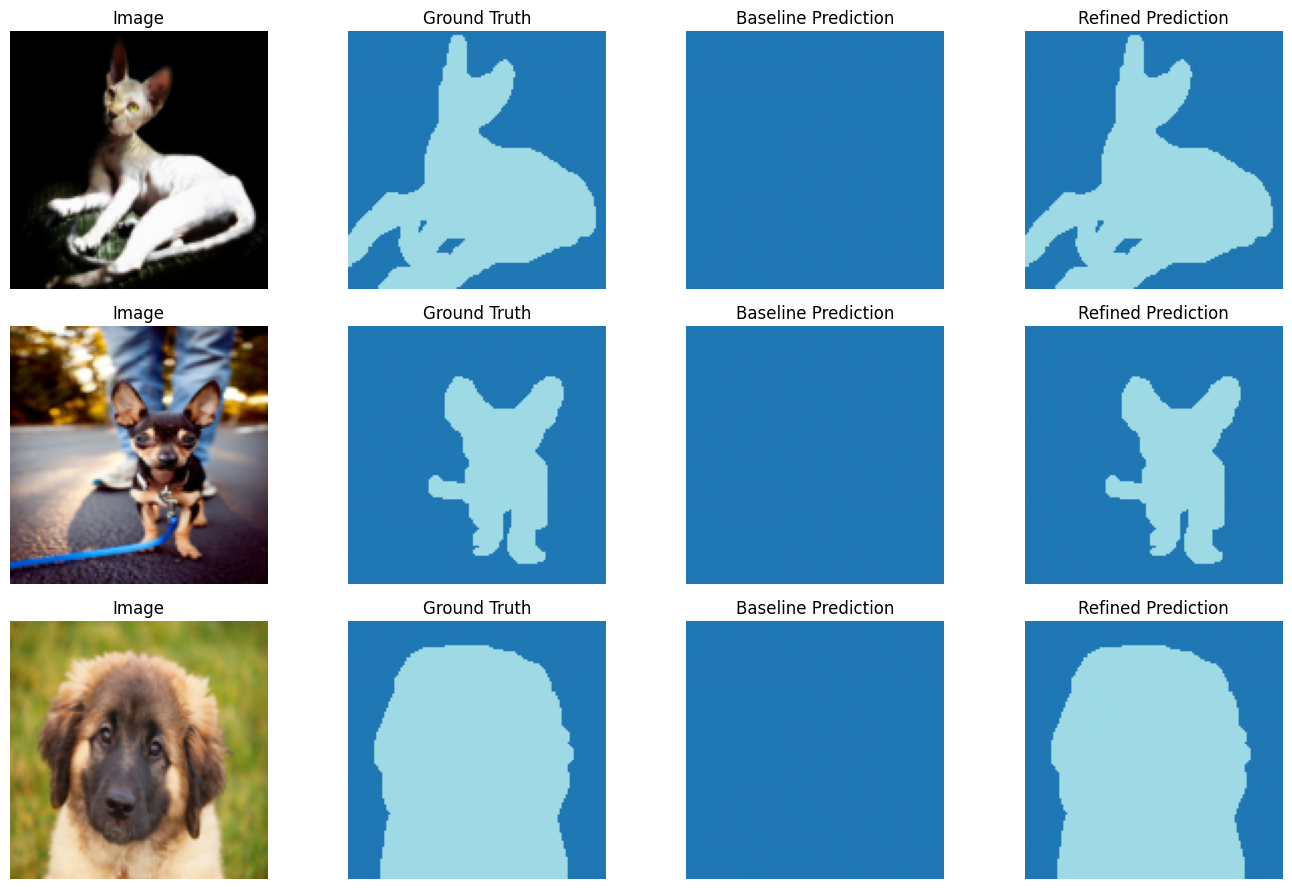

In [ ]:
print("\nVisualizing diffusion refiner predictions...")

n_vis = 3
images, masks = next(iter(test_loader))
images, masks = images[:n_vis].to(device), masks[:n_vis].to(device)

with torch.no_grad():
    pred_mask = torch.randn_like(masks).to(device)
    baseline_logits = baseline_model(images)
    baseline_probs = torch.softmax(baseline_logits, dim=1)
    noise_scheduler.set_timesteps(100, device=device)  # fewer steps for visualization

    baseline_preds = torch.argmax(baseline_probs, dim=1) #only for visualization down

    for t in noise_scheduler.timesteps:

        # input_concat = torch.cat([images, baseline_probs, pred_mask], dim=1)
        input_concat = torch.cat([images, masks, pred_mask], dim=1)

        model_out = refiner(input_concat, t)
        pred = model_out.sample
        step_out = noise_scheduler.step(pred, t, pred_mask)
        pred_mask = step_out.prev_sample

    pred_probs = torch.softmax(pred_mask, dim=1)
    preds = torch.argmax(pred_probs, dim=1)
    gts = masks.argmax(dim=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, n_vis * 3))
for i in range(n_vis):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    # image was in [-1,1], map to [0,1] for display
    img_disp = ((img + 1) / 2).clip(0, 1)

    gt = gts[i].cpu().numpy()
    pr = preds[i].cpu().numpy()
    base = baseline_preds[i].cpu().numpy()

    plt.subplot(n_vis, 4, i * 4 + 1)
    plt.imshow(img_disp)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(n_vis, 4, i * 4 + 2)
    plt.imshow(gt, cmap="tab20")
    plt.axis("off")
    plt.title("Ground Truth")

    plt.subplot(n_vis, 4, i * 4 + 3)
    plt.imshow(base, cmap="tab20")
    plt.axis("off")
    plt.title("Baseline Prediction")

    plt.subplot(n_vis, 4, i * 4 + 4)
    plt.imshow(pr, cmap="tab20")
    plt.axis("off")
    plt.title("Refined Prediction")

plt.tight_layout()
plt.show()
